# Lab CNNs

## Integrantes
- Jose Asitimbay
- Brayan Lechon

# Activities

- Create a CCN model to predict the next word in a sentence.
- Use Cien años de soledad by Gabriel Garcia Marquez as the training text.

# Baseline Neural Network

Importación de librerías


In [43]:
import torch
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# Identificar el GPU y número de dispositivos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())

cuda
4


Procesamiento del texto

In [45]:
# Configuración del procesamiento de texto
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

In [46]:

file_path = '/home/jasitimbayz/Lab4/gabriel_garcia_marquez_cien_annos_soledad.txt'
text = open(file_path, 'r').read().lower()


Tokenización y conteo de palabras

In [47]:
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    # tokens = [ss.stem(w) for w in tokens if w not in sw]
    return tokens

In [48]:
tokens = split_tokens(text)

In [49]:
tokens[:20]

['gabriel',
 'garcía',
 'márquez',
 'cien',
 'años',
 'soledad',
 'editado',
 'ediciones',
 'cueva',
 'j',
 'omi',
 'garcía',
 'ascot',
 'maría',
 'luisa',
 'elio',
 'cien',
 'años',
 'soledad',
 'gabriel']

In [50]:
counts = Counter(tokens)

In [51]:
counts_more_than_1 = {k:v for k,v in counts.items() if v > 1}


Creación del vocabulario y mapeo de tokens

In [52]:
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v:k for k,v in itot.items()}

In [53]:
tokens_more_than_1 = [w for w in tokens if w in vocab]

Let's prepare the window for word2vec

In [54]:
def window(tokens, win=2):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i+j] for j in range(-win, win+1,1)
                  if (i+j >= 0) & (i+j < len(tokens)) & (j != 0)]
       # print(window)
        output += [(target, ttoi[j]) for j in window]
    return output

In [55]:
data_windowed = window(tokens_more_than_1, win=4)

In [56]:
data_windowed[:10]

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 1),
 (6, 9),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 1),
 (7, 9),
 (7, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 1),
 (8, 9),
 (8, 3),
 (8, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 3),
 (1, 4),
 (1, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 1),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 0),
 (3, 7),
 (3, 8),
 (3, 1),
 (3, 9),
 (3, 4),
 (3, 5),
 (3, 0),
 (3, 1),
 (4, 8),
 (4, 1),
 (4, 9),
 (4, 3),
 (4, 5),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 1),
 (5, 9),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 4),
 (0, 9),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 1),
 (0, 2),
 (0, 4),
 (0, 10),
 (1, 3),


Dataset para word2vec

In [57]:
class text_dataset(Dataset):
    def __init__(self, data_windowed, vocab_size):
        self.data = data_windowed
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x0, y = self.data[idx]
        x =  F.one_hot(torch.tensor(x0), num_classes=self.vocab_size)
        return x, y

In [58]:
dataset = text_dataset(data_windowed, len(vocab))

Building de network

In [59]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input.to(torch.int64))
        logits = self.expand(hidden)
        return logits

In [60]:
model = Word2Vec(len(vocab), 100).to(device)

In [63]:
LR = 3e-3
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [64]:
from tqdm import tqdm  

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

# Entrenamiento del modelo usando GPU
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        # Mover los datos a la GPU
        context = context.to(device).to(torch.float)
        center = center.to(device).to(torch.float)

        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)

100%|█████████▉| 77482/77490 [11:36<00:00, 111.70it/s]

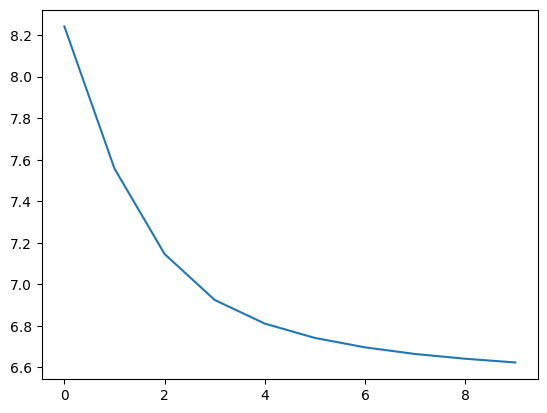

In [65]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [66]:
wordvecs = model.expand.weight.cpu().detach().numpy()

In [67]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

# n * (n-1) / 2
def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, itot[i], dists[i]) for i in ind]
    return out

In [68]:
dmat = get_distance_matrix(wordvecs, 'cosine')
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']
#tokens_test = [ss.stem(w) for w in tokens_test if w not in sw]
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")

aureliano ['segundo', 'coronel', 'buendía', 'arcadio', 'casa', 'josé', 'úrsula', 'sólo', 'dijo', 'después'] 

coronel ['buendía', 'gerineldo', 'aureliano', 'márquez', 'tratado', 'confidencial', 'guerra', 'amigo', 'promover', 'paz'] 

macondo ['habitantes', 'antiguos', 'extremos', 'obreros', 'vivió', 'sierra', 'extraordinario', 'trabajadores', 'calles', 'civil'] 

casa ['úrsula', 'aureliano', 'sino', 'amaranta', 'macondo', 'fernanda', 'después', 'crespi', 'sólo', 'volvió'] 

pueblo ['calle', 'lamentó', 'pasaje', 'respaldo', 'cobraba', 'serviciales', 'lugares', 'júbilo', 'tiendas', 'incomprensibles'] 

melquíades ['leyendas', 'arregló', 'sánscrito', 'corrigió', 'propiedades', 'olvidaran', 'infinita', 'alquimia', 'objetos', 'vinculado'] 

arcadio ['josé', 'buendía', 'aureliano', 'segundo', 'encontró', 'laboratorio', 'hombre', 'quejóse', 'pesar', 'castaño'] 

úrsula ['amaranta', 'casa', 'entonces', 'aureliano', 'dijo', 'cosas', 'fernanda', 'tan', 'sino', 'puerta'] 



# CNN

Importación de las librerías

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import nltk

# Descargar los recursos de NLTK necesarios
nltk.download('stopwords')

# Identificar el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)  # Muestra si está utilizando 'cuda' o 'cpu'
print(torch.cuda.device_count())  # Muestra cuántos dispositivos CUDA hay disponibles


cuda
4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Configuración de herramientas de NLP

In [ ]:
# Configuración de herramientas de NLP
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

# Leer el archivo de texto
file_path = '/home/jasitimbayz/Lab4/gabriel_garcia_marquez_cien_annos_soledad.txt'
text = open(file_path, 'r').read().lower()

# Función para tokenizar y limpiar el texto
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    return tokens

tokens = split_tokens(text)


Conteo de palabras y creación del vocabulario

In [ ]:
# Contar la frecuencia de las palabras
counts = Counter(tokens)
counts_more_than_1 = {k:v for k,v in counts.items() if v > 1}

# Crear vocabulario y diccionarios de conversión
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v:k for k,v in itot.items()}

tokens_more_than_1 = [w for w in tokens if w in vocab]

# Definir el dataset para la CNN
class TextCNN_Dataset(Dataset):
    def __init__(self, tokens, ttoi, seq_len=7):
        self.tokens = tokens
        self.ttoi = ttoi
        self.seq_len = seq_len
        self.pad_idx = len(ttoi)  # Índice para padding

    def __len__(self):
        return len(self.tokens) - self.seq_len

    def __getitem__(self, idx):
        x = self.tokens[idx:idx + self.seq_len]
        y = self.tokens[idx + self.seq_len]
        x = [self.ttoi.get(w, self.pad_idx) for w in x]
        y = self.ttoi.get(y, self.pad_idx)
        return torch.tensor(x), torch.tensor(y)

seq_len = 7  
cnn_dataset = TextCNN_Dataset(tokens_more_than_1, ttoi, seq_len=seq_len)


Definir la arquitectura de la CNN

Definimos la red CNN con tres capas convolucionales (de tamaños 3, 4, y 5), que capturan diferentes n-grams del texto.
Cada capa se pasa por una  ReLU, seguida de una max pooling.
Finalmente, concatenamos los resultados de las tres convoluciones y los pasamos por una fully connected para generar la predicción.

In [ ]:
# Definir la arquitectura de la CNN
class CNN_Text(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, seq_len):
        super(CNN_Text, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim, padding_idx=vocab_size)
        self.conv1 = nn.Conv2d(1, 100, (3, embedding_dim))  # Filtros 3-gram
        self.conv2 = nn.Conv2d(1, 100, (4, embedding_dim))  # Filtros 4-gram
        self.conv3 = nn.Conv2d(1, 100, (5, embedding_dim))  # Filtros 5-gram
        self.fc = nn.Linear(3 * 100, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        x = x.unsqueeze(1)  # (batch_size, 1, seq_len, embedding_dim)
        x1 = F.relu(self.conv1(x)).squeeze(3)  # (batch_size, out_channels, seq_len-3+1)
        x2 = F.relu(self.conv2(x)).squeeze(3)
        x3 = F.relu(self.conv3(x)).squeeze(3)

        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
        x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)

        x = torch.cat((x1, x2, x3), 1)
        logits = self.fc(x)
        return logits


In [ ]:
# Definir el modelo
embedding_dim = 100
model = CNN_Text(len(vocab), embedding_dim, len(vocab), seq_len).to(device)

# Definir el DataLoader
cnn_dataloader = DataLoader(cnn_dataset, batch_size=64, shuffle=True)

# Definir la función de pérdida y optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

# Lista para almacenar la pérdida de cada época
epoch_losses = []

# Entrenamiento
EPOCHS = 50
for epoch in range(EPOCHS):
    epoch_loss = 0
    for inputs, targets in cnn_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(cnn_dataloader)
    epoch_losses.append(epoch_loss)  # Almacenar la pérdida de la época
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss}')


Epoch 1/50, Loss: 8.313272023963732
Epoch 2/50, Loss: 7.942216668950761
Epoch 3/50, Loss: 7.656192968012256
Epoch 4/50, Loss: 7.2261972314187
Epoch 5/50, Loss: 6.618507967398755
Epoch 6/50, Loss: 5.954586883816557
Epoch 7/50, Loss: 5.3662753016587015
Epoch 8/50, Loss: 4.907190441962243
Epoch 9/50, Loss: 4.543695119389317
Epoch 10/50, Loss: 4.266327288128643
Epoch 11/50, Loss: 4.033934960055277
Epoch 12/50, Loss: 3.8403051832019974
Epoch 13/50, Loss: 3.695014100571781
Epoch 14/50, Loss: 3.5626405326205512
Epoch 15/50, Loss: 3.4464602194826424
Epoch 16/50, Loss: 3.3565682516009447
Epoch 17/50, Loss: 3.2739167324160645
Epoch 18/50, Loss: 3.2043771405461157
Epoch 19/50, Loss: 3.136767948621075
Epoch 20/50, Loss: 3.100580548969462
Epoch 21/50, Loss: 3.0279114146719777
Epoch 22/50, Loss: 2.9732809334962607
Epoch 23/50, Loss: 2.9415938630315663
Epoch 24/50, Loss: 2.9133849730801655
Epoch 25/50, Loss: 2.872166856154569
Epoch 26/50, Loss: 2.8479274197628626
Epoch 27/50, Loss: 2.81579963710655
E

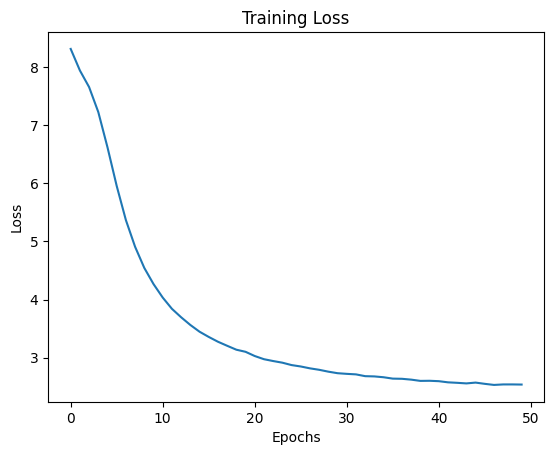

In [ ]:
# Visualización de la pérdida
import matplotlib.pyplot as plt

# Graficar la pérdida de cada época
plt.plot(range(EPOCHS), epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [ ]:
# Extraer los embeddings aprendidos del modelo
word_embeddings = model.embedding.weight.cpu().detach().numpy()


Extraemos los embeddings aprendidos por la red y calculamos la matriz de distancias entre los vectores de palabras usando la distancia de coseno.

In [ ]:
from scipy.spatial import distance

# Función para calcular la matriz de distancias
def get_distance_matrix(word_embeddings, metric='cosine'):
    dist_matrix = distance.squareform(distance.pdist(word_embeddings, metric))
    return dist_matrix

# Calcular la matriz de distancias usando la métrica coseno
distance_matrix = get_distance_matrix(word_embeddings, 'cosine')


In [ ]:
import numpy as np

# Encontramos las palabras más similares
def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]  # Obtener el índice de la palabra
    dists = dist_matrix[idx]  # Obtener las distancias de esta palabra a todas las demás
    ind = np.argpartition(dists, k)[:k+1]  # Encontrar los índices de las k palabras más cercanas
    ind = ind[np.argsort(dists[ind])][1:]  # Ordenar por distancia y excluir la propia palabra
    out = [(i, itot[i], dists[i]) for i in ind]  # Devolver los índices, palabras y distancias
    return out

# Probar algunas palabras
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']

for word in tokens_test:
    similar_words = get_k_similar_words(word, distance_matrix, k=10)
    print(f"Palabras similares a '{word}': {[t[1] for t in similar_words]}\n")


Palabras similares a 'aureliano': ['guardia', 'intrusa', 'pelo', 'gastos', 'fila', 'descendió', 'laurel', 'comunicó', 'tropel', 'pálido']

Palabras similares a 'coronel': ['concebido', 'ataúd', 'don', 'perturbadora', 'cejas', 'victorio', 'búsqueda', 'bordes', 'perdió', 'veían']

Palabras similares a 'macondo': ['carecía', 'pezones', 'local', 'pensaba', 'guardó', 'comprarle', 'encarcelar', 'sonreír', 'mecánico', 'sala']

Palabras similares a 'casa': ['podía', 'divulgó', 'belleza', 'quedó', 'puso', 'carecía', 'nadie', 'tiempo', 'conmovió', 'amaranta']

Palabras similares a 'pueblo': ['asediado', 'persuadir', 'anacrónico', 'llevaba', 'aquella', 'tardía', 'propietaria', 'despidió', 'loco', 'lámpara']

Palabras similares a 'melquíades': ['úrsula', 'populares', 'actitud', 'sencillamente', 'pasara', 'llanura', 'compadeció', 'formado', 'convencido', 'atención']

Palabras similares a 'arcadio': ['identificados', 'derrotado', 'poltronas', 'fila', 'intrusa', 'entonces', 'pidió', 'comisión', 'espe

## Conclusiones

- Como se puede observar en los gráficos, la CNN presenta una mejor performance ya que la CNN está utilizando múltiples capas convolucionales para capturar diferentes patrones en el texto y combinarlos para hacer las predicciones.
- La que usa la CNN utiliza diferentes tamaños de filtros (3-gram, 4-gram y 5-gram) que ayudan a capturar patrones más ricos y diversas combinaciones de palabras en el texto. Esto permite a la red identificar no solo relaciones entre palabras cercanas, sino también contextos más amplios, lo que contribuye a una mayor precisión.